<h2> Shrink datasets down to mz, try to classify them, then try to combine features </h2>

You'll have to... mean center and standardize all your features?

In [540]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from IPython.display import display

import pickle

# My code
import data.preprocessing as preproc
import util.combine_by_mz as combine_mz
import util.rt_window_prediction as rtwin

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Start with mtbls315
load up the data

In [260]:
### import two datasets
def reindex_xcms_by_mzrt(df):
    df.index = (df.loc[:,'mz'].astype('str') + 
               ':' + df.loc[:, 'rt'].astype('str'))
    return df

local_path = ('/home/irockafe/Dropbox (MIT)/Alm_Lab/' +
'projects/')
# malaria
malaria_path = (local_path + '/revo_healthcare/data/processed/MTBLS315/'+
            'uhplc_pos/xcms_result_4.csv')
df_malaria_raw = pd.read_csv(malaria_path, index_col=0)

# convert column names to remove X added to them
new_idx = [i.replace('X', '') for i in df_malaria_raw.columns]
df_malaria_raw.columns = new_idx
print df_malaria_raw.columns
# replace 0 values with nans, so it's easier to replace them later
df_malaria_raw = df_malaria_raw.replace(to_replace=0.0 , value=np.nan, )

# Make a new index of mz:rt
mz = df_malaria_raw.loc[:,"mz"].astype('str')
rt = df_malaria_raw.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df_malaria_raw.index = idx

# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'uhplc_pos', 
               ]
samples_list = df_malaria_raw.columns.difference(not_samples)
mz_rt_df = df_malaria_raw[not_samples]

# convert to samples x features
X_df_malaria_raw = df_malaria_raw[samples_list].T

print "original shape: %s \n# nans: %f\n" % (X_df_malaria_raw.shape, X_df_malaria_raw.isnull().sum().sum())

Index([u'mz', u'mzmin', u'mzmax', u'rt', u'rtmin', u'rtmax', u'npeaks',
       u'uhplc_pos', u'1001_P', u'1002_P', u'1003_P', u'1004_P', u'1005_P',
       u'1006_P', u'1007_P', u'1009_P', u'1010_P', u'1011_P', u'1012_P',
       u'1013_P', u'1014_P', u'1016_P', u'1017_P', u'1018_P', u'1019_P',
       u'1020_P', u'1021_P', u'1023_P', u'1024_P', u'1026_P', u'1027_P',
       u'1029_P', u'1030_P', u'1031_P', u'1032_P', u'1033_P', u'1034_P',
       u'1035_P', u'1036_P', u'1037_P', u'1038_P', u'1039_P', u'1040_P',
       u'1041_P', u'1042_P', u'1043_P', u'1044_P', u'1045_P', u'1046_P',
       u'1048_P', u'1049_P', u'1050_P', u'1051_P', u'1052_P', u'1053_P',
       u'1054_P', u'1055_P', u'1056_P', u'1057_P', u'1058_P', u'1059_P',
       u'1060_P', u'1061_P', u'1062_P', u'1064_P', u'1065_P', u'1066_P',
       u'1067_P', u'1068_P'],
      dtype='object')
original shape: (61, 6737) 
# nans: 3727.000000



# Mapping between class, sample name, run name

In [261]:
# Get mapping between sample name and assay names
path_sample_name_map = (local_path + 'revo_healthcare/data/raw/' +
                'MTBLS315/metadata/a_UPLC_POS_nmfi_and_bsi_diagnosis.txt')

# Sample name to Assay name
# Index is the sample name
# value we want is the Assay name
sample_df = pd.read_csv(path_sample_name_map, 
                        sep='\t', index_col=0)
sample_df = sample_df['MS Assay Name']
sample_df.shape

# sample name to sample class
path_sample_class_map = (local_path + 'revo_healthcare/data/raw/' +
                        'MTBLS315/metadata/s_NMFI and BSI diagnosis.txt')
class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
class_df.set_index('Sample Name', inplace=True)
class_df = class_df['Factor Value[patient group]']

# Combine sample > assay and sample > class into one
class_map_df = pd.concat([sample_df, class_df], axis=1)
class_map_df.rename(columns={'Factor Value[patient group]': 'class'}, inplace=True)

# convert all non-malarial classes into a single classes 
# (collapse non-malarial febril illness and bacteremia together)
binary_class_map = class_map_df.replace(to_replace=['non-malarial febrile illness', 'bacterial bloodstream infection' ], 
                                        value='non-malarial fever')

print "binary class map:\n", binary_class_map.head()

# Get case and control samples in their own dataframes
case_str = 'malaria'
control_str = 'non-malarial fever'
# get that assay names based on class
case_labels = binary_class_map[binary_class_map['class'] == case_str]['MS Assay Name']
control_labels = binary_class_map[binary_class_map['class'] == control_str]['MS Assay Name']
# select the assay names from X_df_raw based on class
case = X_df_malaria_raw.loc[case_labels]
control = X_df_malaria_raw.loc[control_labels]

print 'case shape: ', case.shape
print 'control shape: ', control.shape

binary class map:
            MS Assay Name               class
Sample Name                                  
MCMA429            1001_P             malaria
MCMA430            1002_P             malaria
MCMA431            1003_P             malaria
MCMA433            1004_P             malaria
MCMA434            1005_P  non-malarial fever
case shape:  (34, 6737)
control shape:  (27, 6737)


In [262]:
# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(binary_class_map['class'])
assert(binary_class_map['MS Assay Name'] == X_df_malaria_raw.index).all()
y_malaria = le.transform(binary_class_map['class'])
y_malaria

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

<h2> Get p. vivax data to useful format </h2>

In [12]:
# Get p. vivax data
project_path = ('/revo_healthcare/data/processed/' +
                'ST000578/ST000578_AN000888_Results.tsv')

p_vivax_path = local_path + project_path
df_p_vivax = pd.read_csv(p_vivax_path, sep='\t')



/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,2

In [13]:
## Parse the class-labels from output
outcome = df_p_vivax.iloc[0,:]
print outcome.unique()

# convert all P. vivax into just P.vivax
susceptible_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Susceptible')]

resistant_triplicate = outcome[outcome.str.contains('Current Malaria Infection:P.Vivax') & 
        outcome.str.contains('Chloroquine Resistance:Resistant')]

control_triplicate = outcome[outcome.str.contains('Current Malaria Infection:None') ]
print '\n\nSusceptible\n', susceptible_triplicate.shape[0] / 3
print '\n\nResistant\n', resistant_triplicate.shape[0] / 3
print '\n\nControl\n', control_triplicate.shape[0] /3
# Select one of the three triplicate samples ( the one that doesn't have a period in the name)
resistant = resistant_triplicate[~resistant_triplicate.index.str.contains('\.')]
susceptible = susceptible_triplicate[~susceptible_triplicate.index.str.contains('\.')]
control = control_triplicate[~control_triplicate.index.str.contains('\.')]

# Relabel so that only three classes
resistant[:] = 'Chloroquine resistant'
susceptible[:] = 'Chloroquine susceptible'
control[:] = 'Control'

class_labels = pd.concat([resistant, susceptible, control])
print "how many samples?\n", class_labels.shape
print "What are the classes?\n", class_labels.unique()


['Factors'
 'Current Malaria Infection:None | Prior Malaria Infection:N/A | Chloroquine Resistance:N/A'
 'Current Malaria Infection:None | Prior Malaria Infection:NO | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:NO | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Susceptible'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:YES | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:None | Prior Malaria Infection:YES | Chloroquine Resistance:N/A'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:NO | Chloroquine Resistance:Resistant'
 'Current Malaria Infection:P.Vivax | Prior Malaria Infection:N/A | Chloroquine Resistance:Resistant']


Susceptible
33


Resistant
31


Control
66
how many samples?
(123,)
What are the classes?
['Chloroquine resi

<h2> Parse the feature table and encode the class labels </h2>

In [16]:
# Grab samples that have correct class labels
# get rid of the class-label row
df_p_vivax_raw = df_p_vivax.iloc[1:, :]
# index based on the 'sample' row
df_p_vivax_raw = df_p_vivax_raw.set_index(df_p_vivax_raw['Samples'])
# Keep only samples and convert to (samples x features)
df_p_vivax_raw = df_p_vivax_raw[class_labels.index].T
display(df_p_vivax_raw.head())

# remove first column and convert to float
print "df_p_vivax_raw shape", df_p_vivax_raw.shape
print "class labels", class_labels.shape

# Make sure labels and df_p_vivax_raw-columns are in matching order
print "quick eyeball that y and X are in same order ", zip(df_p_vivax_raw.columns, class_labels.index)[0:5]
assert (df_p_vivax_raw.index == class_labels.index).all()
display(df_p_vivax_raw.head())

# Conver to binary class labels
print class_labels.unique()
le = preprocessing.LabelEncoder()
le.fit(class_labels)
y_pvivax = le.transform(class_labels)
print y_pvivax



Samples,85.5089_36.2,85.5146_37.6,86.0955_48.6,86.5166_270.6,87.0429_204.8,87.0432_263.8,87.0988_50.9,87.5085_353.2,87.5086_13.4,88.0747_258.9,...,1762.6041_417.6,1763.1075_417.3,1810.4472_46.3,1810.4763_411.8,1815.3909_407.5,1982.3328_417.0,1982.8332_416.7,1983.3337_417.2,1983.8177_417.2,1984.3186_417.5
2009227,51065.03274,34348.85255,880363.6806,0,0,0,0,0,134251.0278,0,...,0,0,0,0,0,124759,0,1036.54,0,0
2008791,22154.69474,49230.82536,1057405.156,125925.8035,0,0,0,234774.6689,37484.24267,0,...,0,0,0,0,0,430687,2.06874e+06,460889,40449.8,322134
2008700,0,70190.04916,1362530.042,0,0,115557.2717,48285.29025,282774.3529,155057.2188,0,...,0,510225,0,0,0,469729,369764,714522,0,322114
2008675,26024.15828,36202.7997,1204027.617,233731.1325,186770.4664,0,25228.12601,156219.2191,227745.6642,0,...,0,0,0,0,0,568305,295861,760267,0,72068.8
2008630,0,242840.7866,1139145.689,0,0,0,42667.85198,189666.9579,177576.6134,0,...,0,0,0,0,0,623452,362512,874229,0,697438


df_p_vivax_raw shape (123, 20347)
class labels (123,)
quick eyeball that y and X are in same order  [('85.5089_36.2', '2009227'), ('85.5146_37.6', '2008791'), ('86.0955_48.6', '2008700'), ('86.5166_270.6', '2008675'), ('87.0429_204.8', '2008630')]


Samples,85.5089_36.2,85.5146_37.6,86.0955_48.6,86.5166_270.6,87.0429_204.8,87.0432_263.8,87.0988_50.9,87.5085_353.2,87.5086_13.4,88.0747_258.9,...,1762.6041_417.6,1763.1075_417.3,1810.4472_46.3,1810.4763_411.8,1815.3909_407.5,1982.3328_417.0,1982.8332_416.7,1983.3337_417.2,1983.8177_417.2,1984.3186_417.5
2009227,51065.03274,34348.85255,880363.6806,0,0,0,0,0,134251.0278,0,...,0,0,0,0,0,124759,0,1036.54,0,0
2008791,22154.69474,49230.82536,1057405.156,125925.8035,0,0,0,234774.6689,37484.24267,0,...,0,0,0,0,0,430687,2.06874e+06,460889,40449.8,322134
2008700,0,70190.04916,1362530.042,0,0,115557.2717,48285.29025,282774.3529,155057.2188,0,...,0,510225,0,0,0,469729,369764,714522,0,322114
2008675,26024.15828,36202.7997,1204027.617,233731.1325,186770.4664,0,25228.12601,156219.2191,227745.6642,0,...,0,0,0,0,0,568305,295861,760267,0,72068.8
2008630,0,242840.7866,1139145.689,0,0,0,42667.85198,189666.9579,177576.6134,0,...,0,0,0,0,0,623452,362512,874229,0,697438


['Chloroquine resistant' 'Chloroquine susceptible' 'Control']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]


In [5]:
# Get map between feature names and mz, rt
df_p_vivax_raw.columns
mz_rt_list = [i.split('_') for i in df_p_vivax_raw.columns]
feature_map = pd.DataFrame(mz_rt_list, columns=['mz', 'rt'], index=df_p_vivax_raw.columns)

display(feature_map.head())

NameError: name 'df_p_vivax_raw' is not defined

# Preprocess
MTBLS315 first, since we know it can classify well


In [1]:
# Don't normalize by dilution factor - have seen that doesn't help
# do set prevalence threshold
thresh = 0.5
X_df_malaria_filter = preproc.prevalence_threshold(X_df_malaria_raw, thresh)
print "raw shape", X_df_malaria_raw.shape
print "50% filter shape", X_df_malaria_filter.shape

# fill nans with 1/2 min from each sample
fill = X_df_malaria_filter.min(axis=1) / 2.0
X_df_malaria_filter_filled = X_df_malaria_filter.T.fillna(value=fill).T
# sanity check
print "how many nulls?", X_df_malaria_filter.isnull().sum().sum()
print "how many nulls?", X_df_malaria_filter_filled.isnull().sum().sum()

NameError: name 'preproc' is not defined

# collapse rt

In [264]:
ppm = 30

# add mz and rt vals into dataframe
print df_malaria_raw.shape
mz_malaria = df_malaria_raw.loc[X_df_malaria_filter_filled.columns]['mz']

ppm_mat_malaria = combine_mz.ppm_matrix(mz_malaria, mz_malaria)

(6737, 69)


In [265]:
# make triangular
test = np.array(np.arange(1,10), dtype=np.float).reshape([3,3])
display(test)
display(np.tril(test, k=-1))

idx = np.tril_indices(test.shape[0])

test[idx] = np.nan
print test

# Convert to upper triangular matrix
idx_ppm = np.tril_indices(ppm_mat_malaria.shape[0])
ppm_mat_malaria[idx_ppm] = np.nan

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.]])

array([[ 0.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 7.,  8.,  0.]])

[[ nan   2.   3.]
 [ nan  nan   6.]
 [ nan  nan  nan]]


In [266]:
ppm_mat_malaria

array([[             nan,   9.80917292e+03,   9.83392448e+03, ...,
          8.98246100e+05,   8.98348785e+05,   8.98451299e+05],
       [             nan,              nan,   2.49967620e+01, ...,
          8.97238091e+05,   8.97341793e+05,   8.97445322e+05],
       [             nan,              nan,              nan, ...,
          8.97235522e+05,   8.97339227e+05,   8.97442759e+05],
       ..., 
       [             nan,              nan,              nan, ...,
                     nan,   1.00915190e+03,   2.01661639e+03],
       [             nan,              nan,              nan, ...,
                     nan,              nan,   1.00848220e+03],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan]])

# Ignore the runtime errors - just means we're ignoring hte nans like i want to

In [267]:
print '# of overlaps:', (ppm_mat_malaria < ppm).sum()

# of overlaps: 3405


/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


## This doesn't give us the number of features, tho. That's the goal

In [92]:
def group_by_mz(mat, ppm):
    '''
    Given square matrix from ppm comparison,
    group all isomers together
    '''
    isomers = np.argwhere(mat < ppm)
    print np.nonzero(mat < ppm)


# match (a,b), (c,d), no others
toy = np.array([[np.nan]*4,
               [0.1, np.nan, np.nan, np.nan],
               [10,100, np.nan, np.nan],
               [20,200,0.2, np.nan]
               ])
print toy
group_by_mz(toy, 1)

[[             nan              nan              nan              nan]
 [  1.00000000e-01              nan              nan              nan]
 [  1.00000000e+01   1.00000000e+02              nan              nan]
 [  2.00000000e+01   2.00000000e+02   2.00000000e-01              nan]]
[[False False False False]
 [ True False False False]
 [False False False False]
 [False False  True False]]
[[1 0]
 [3 2]]
(array([1, 3]), array([0, 2]))


/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [285]:
def group_isomer_indices(indices):
    '''
    Given a list of isomer pairs, combine all isomers pairs into 
    a single group - i.e. [[0,1], [1,5]] becomes [0,1,5]
    '''
    output = []
    for idx in indices:
        #print '\n\nfinding indices that match ', idx 
        # Find any matches to the current index in the list of indices
        match_idx = np.argwhere([np.in1d(idx, poop).any() for poop in indices])
        #print 'Indices that match\n', match_idx
        #print 'Do these match %s?: \n %s' % (idx, indices[match_idx])
        unique_matches = np.unique(indices[match_idx])
        #print 'Unique matches', unique_matches
        
        # Check if any values from unique_matches are present in output
        # if not, append
        # if so, append to place where they're found
        in_output = [np.in1d(unique_matches, poop).any() for poop in output]
        #print 'Output\n', output
        #print 'Is it in the output?\n', in_output
        where_in_output = np.argwhere(in_output)
        #print 'Where?\n', where_in_output, 'Size', where_in_output.size, 'Greater than 1?', where_in_output.size
        
        
        # if found in output, append it to where you found it in the output
        if  where_in_output.size != 0:
            if where_in_output.size > 1:
                raise ValueError('You should only find an index one place in the output. Somehting is wrong')
            #print 'Append unique vals to entry that overlaps in output'
            #print int(where_in_output)
            #print output[int(where_in_output)]
            
            output[int(where_in_output)] = np.append(output[int(where_in_output)], unique_matches)
        # If not found in an entry of the output, append values found to the output 
        else:
            output.append(unique_matches)
        #print 'Output', output
        #
    output = [np.unique(poop) for poop in output]
    #print ('-'*50, 'Final output\n', output)
    return output


test = np.array([[0,1], [2,3], [0,4], [4,5], [1,6]])

iso = group_isomer_indices(test)
print test
print iso


[[0 1]
 [2 3]
 [0 4]
 [4 5]
 [1 6]]
[array([0, 1, 4, 5, 6]), array([2, 3])]


In [275]:
ppm = 30
isomer_indices = np.argwhere(ppm_mat_malaria < 30)
isomer_indices.shape
print isomer_indices[0:10]

[[ 1  2]
 [ 4  5]
 [10 11]
 [10 12]
 [11 12]
 [18 19]
 [18 20]
 [19 20]
 [36 37]
 [36 38]]


/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [286]:
isomer_groups = group_isomer_indices(isomer_indices)
print isomer_groups

[array([1, 2]), array([4, 5]), array([10, 11, 12]), array([18, 19, 20]), array([36, 37, 38]), array([41, 42]), array([47, 48, 49, 50, 51, 52, 53]), array([54, 55]), array([64, 65]), array([67, 68, 69, 70]), array([73, 74, 75, 76, 77]), array([80, 81]), array([82, 83]), array([97, 98, 99]), array([101, 102]), array([103, 104]), array([126, 127]), array([128, 129, 130]), array([134, 135]), array([137, 138, 139, 140]), array([141, 142, 143]), array([148, 149, 150, 151]), array([152, 153, 154]), array([155, 156, 157]), array([161, 162, 163, 164, 165]), array([166, 167]), array([168, 169]), array([170, 171, 172]), array([173, 174, 175]), array([179, 180]), array([184, 185]), array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199]), array([200, 201, 202]), array([205, 206]), array([209, 210, 211]), array([220, 221, 222]), array([231, 232]), array([236, 237]), array([239, 240, 241]), array([243, 244, 245]), array([251, 252]), array([259, 260]), array([261, 262]), array([272, 273]), array([27

In [290]:
mtbls315_path = '/revo_healthcare/presentations/isaac_bats/rt_window_plots/MTBLS315/'
output = local_path + mtbls315_path + 'isomer_indices.pkl'
pickle.dump(isomer_groups, open(output, 'wb'))

Number of isomer groups: 1225
Number of features that make up those groups isomers 3358


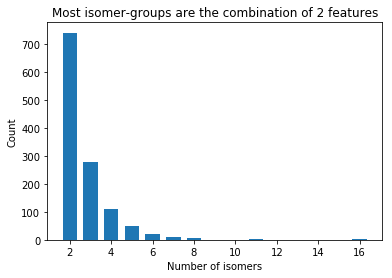

In [483]:
print 'Number of isomer groups:',  len(isomer_groups)
print 'Number of features that make up those groups isomers', np.concatenate(isomer_groups).size
group_size = [len(i) for i in isomer_groups]
plt.hist(group_size, bins=range(min(group_size), max(group_size)), 
        align='left', rwidth=0.7)
plt.title('Most isomer-groups are the combination of 2 features')
plt.xlabel('Number of isomers')
plt.ylabel('Count')
plt.savefig(local_path + mtbls315_path + '/number_of_features_per_isomer_group.pdf', 
           format='pdf')
plt.show()

# Now Learn to sum intensities of isomer features, remove (? or treat as feature engineering?) others

In [526]:
def sum_isomer_intensities(df, isomer_groups):
    '''
    GOAL - Sum the intensity values of isomers
    INPUT - 
        df (samples x features) of intensity values
        isomer_groups - np array of arrays
    OUTPUT - 
        dataframe containing the summed values
        mapping between name of feature and values that make it up
    '''
    feature_names = ['isomer_group_%s' % i 
                     for i in range(0,len(isomer_groups))]
    output_df = pd.DataFrame(index=df.index, columns=feature_names)
    feature_mapping = pd.Series(index=feature_names)
    
    count = 0
    for i, group in enumerate(isomer_groups):
        summed_val = df.iloc[:,group].sum(axis=1, skipna=True)
        # Add to dataframe
        output_df['isomer_group_%s' % i] = summed_val
        feature_mapping['isomer_group_%s' % i] = np.array(df.iloc[:, group].columns)
        #if type(df.iloc[:, group].columns == )
        count += len(np.array(df.iloc[:, group].columns))
    print 'Final count', count
    return output_df, feature_mapping

df_summed_isomers, summed_isomer_features = sum_isomer_intensities(
    X_df_malaria_filter_filled, isomer_groups)

# Double check that # of isomers is same in df and group
print 'original size', np.concatenate(isomer_groups).size  
print 'other shapes', summed_isomer_features.shape
print 'summed_df shape', df_summed_isomers.shape                                   

Final count 3358
original size 3358
other shapes (1225,)
summed_df shape (61, 1225)


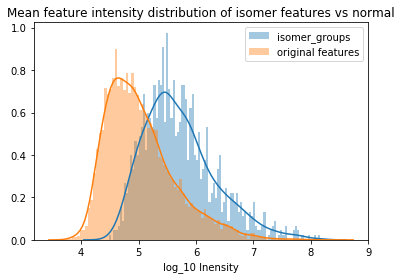

In [488]:
# TODO - decide if these need to be normalized...?
sns.distplot(np.log10(summed_isomer_df).mean(axis=0), bins=100,
        label='isomer_groups')
sns.distplot(np.log10(X_df_malaria_filter_filled).mean(axis=0), bins=100,
        label='original features' )
plt.xlabel('log_10 Inensity')
plt.legend()
plt.title('Mean feature intensity distribution of isomer features vs normal')
plt.show()
plt.close()

(34, 1225)
ctrl (27, 1225)


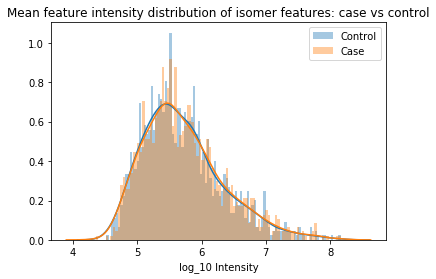

In [489]:
# Case and control look about the same
# How does case/control of isomer features look?
case_poop = summed_isomer_df.loc[case_labels]
ctrl_poop = summed_isomer_df.loc[control_labels]
print case_poop.shape
print 'ctrl', ctrl_poop.shape
sns.distplot(np.log10(ctrl_poop).mean(axis=0),
            bins=100, label='Control')
sns.distplot(np.log10(case_poop).mean(axis=0), bins=100,
            label='Case')
plt.legend()
plt.title('Mean feature intensity distribution of isomer ' +
          'features: case vs control')
plt.xlabel('log_10 Intensity')
plt.show()

## Now let's try to classify by removing the features from isomer groups and adding new features

In [535]:
# Remove features
print summed_isomer_features.values
isomer_idx = np.concatenate(summed_isomer_features.values)

#print summed_isomer_features.values
#print summed_isomer_index.get_level_values(0)
isomers_to_drop = X_df_malaria_filter_filled[isomer_idx]
print 'Shape of original', X_df_malaria_filter_filled.shape
print 'Shape of what to drop, should be 3358', isomers_to_drop.shape

[ array(['102.008758281:39.019987471', '102.011308234:39.0611977932'], dtype=object)
 array(['103.005418678:39.0289939892', '103.008163158:38.9530452658'], dtype=object)
 array(['104.106482797:769.364889063', '104.106436464:46.4052594739',
       '104.106485307:798.017378255'], dtype=object)
 ...,
 array(['879.671423793:792.320765852', '879.692213794:397.480873199'], dtype=object)
 array(['896.534826858:954.927273907', '896.554808795:1015.60791894',
       '896.564938271:1044.58261003'], dtype=object)
 array(['908.69010713:811.066920876', '908.696864178:531.392078889'], dtype=object)]
Shape of original (61, 6737)
Shape of what to drop, should be 3358 (61, 3358)


In [539]:
# Drop and add
X_df_malaria_filter_filled_isomers_grouped = pd.concat([
    # drop first
    X_df_malaria_filter_filled.drop(isomers_to_drop.columns, axis=1)
    ,
    df_summed_isomers], axis=1)
print 'new shape. Should be 4604', X_df_malaria_filter_filled_isomers_grouped.shape


new shape. Should be 4604 (61, 4604)


['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 'npeaks', 'uhplc_pos']
RT plot (0.0, 1495.6946680256501)
1495.69466803
994.676795832


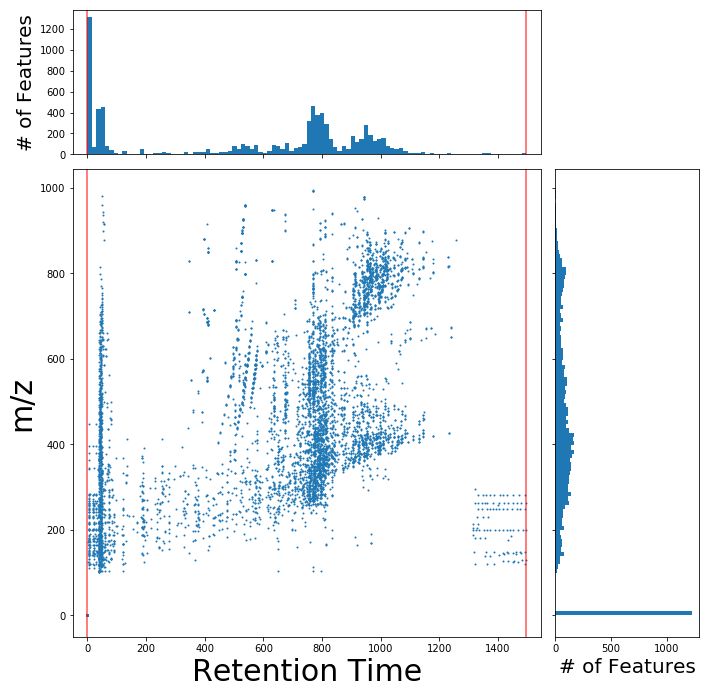

slice shape (61, 6736)
y shape (61,)
0.0% done! 3.47418117523s elapsed


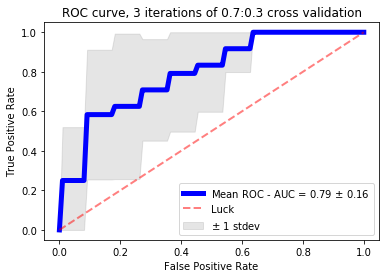




--------------------------------------------------NEXT ROUND--------------------------------------------------





array([[ 0.85227273,  0.95454545,  0.56818182]])

In [567]:
print not_samples

# combine the rt back
X = (pd.concat([X_df_malaria_filter_filled_isomers_grouped,
              df_malaria_raw[not_samples].T], axis=0)
     .T
     .fillna(value=0)
    )

min_val = 0
max_val = df_malaria_raw['rt'].max()
width = max_val 
step = width 
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)

# run classifier on all data
n_iter = 3
test_size = 0.3
rf_trees = 1000
all_aucs = np.full([len(sliding_window), n_iter], np.nan)
path = ('/revo_healthcare/presentations/isaac_bats/' +
        'combine_isomers')
output_path = local_path + path

# Run rt-sliding-window classifier
rtwin.sliding_rt_window_aucs(X, y_malaria, sliding_window, not_samples,
                      rf_trees=rf_trees, n_iter=n_iter, test_size=test_size,
                      output_path=output_path)